In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mwparserfromhell
import string
import vaderSentiment
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

# Loading Data

And correct some date inconcistencies

In [2]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r', encoding="utf8") as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
original_df = df.copy()
df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
78697,Leonard^Bloom,Milk's Favorite Cookie,1,-1,2008,"17:23, 22 July 2008","'''Strong Support''' Wonderful contributions, ..."
133400,Pschemp,Elf-friend,1,1,2006,"02:21, 11 February 2006",'''Support'''. [[User:Pschemp|<small><font col...
191448,Alan Au,Zappaz,0,-1,2005,"07:06, 10 September 2005",Between the controversy and the odd distributi...


In [3]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

# Convert Year to int
df['Year'] = df['Year'].astype(int)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
25361,Unionhawk,Shirik,1,1,2010,2010-04-26 17:08:00,"'''Support''' - all right, I'm convinced now...--"
36324,Davewild,Franamax,1,1,2009,2009-11-05 07:52:00,'''Support''' I don't see anything that makes ...
119335,Rudget,Mercury,0,-1,2007,2007-12-28 22:44:00,"'''Neutral''' - I like this editor, but oppose..."


In [4]:
# Select users with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
users_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].groupby('Target').size() >= 6
users_with_duplicates = users_with_duplicates[users_with_duplicates].index
duplicates = df[df.Target.isin(users_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: 1 if x['1'] >= 70 else -1, axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'].astype(int), axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year)

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull() & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
187045,Kelly Martin,Alphax,1,-1,2005.0,2005-10-18 15:32:00,'''Support'''. I am tired of being asked by t...
41036,Drilnoth,Plastikspork,1,1,2009.0,2009-06-18 21:27:00,Being the nom and all... '''support'''. –
75572,Daniel Case,Geni,1,-1,2008.0,2008-08-25 02:13:00,'''Support'''. I never had any personal issues...


# -- Sentiment analysis --

## Showing differences between removing the headers (support, neutral, oppose) vs keeping them

In [34]:
# Libraries
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [6]:
#Parse the comments to a new column
df_comment = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

df_comment['Comment'] = df_comment['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_comment["Parsed_Comment"] = df_comment.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

In [7]:
#Initialize a dataframe containing only relevant info for futur comment analysis
stat_df = pd.DataFrame(columns = ['Source','Vote', 'Comment', 'Parsed_Comment'])
stat_df['Vote']=df_comment['Vote']
stat_df['Source']=df_comment['Source']
stat_df['Comment'] = df_comment['Comment']
stat_df['Parsed_Comment']=df_comment['Parsed_Comment']

In [53]:
# Strings to remove for sentiment analysis without headers (support, oppose, neutral)

df_sentiment = df_comment.copy()
df_sentiment_with_headers = df_comment.copy()

support_pattern = re.compile(r'^\bsupport\w*\b', flags=re.IGNORECASE)
df_sentiment["Parsed_Comment"] = df_sentiment["Parsed_Comment"].str.replace(support_pattern, '', regex=True)
neutral_pattern = re.compile(r'^\bneutral\w*\b', flags=re.IGNORECASE)
df_sentiment["Parsed_Comment"] = df_sentiment["Parsed_Comment"].str.replace(neutral_pattern, '', regex=True)
oppose_pattern = re.compile(r'^\boppose\w*\b', flags=re.IGNORECASE)
df_sentiment["Parsed_Comment"] = df_sentiment["Parsed_Comment"].str.replace(oppose_pattern, '', regex=True)

#strings_to_remove = ['support', 'neutral', 'oppose']

#for string in strings_to_remove:
 #   df_sentiment["Parsed_Comment"] = df_sentiment["Parsed_Comment"].str.replace(string, '', case=False)

In [70]:
print("\n---Without headers--- \n", df_sentiment["Parsed_Comment"][1120:1130])
print("\n---With headers--- \n", df_sentiment_with_headers["Parsed_Comment"][1120:1130])


---Without headers--- 
 1123     - Never let perfection get in the way of good...
1124                       Supporting coz I trust nom. --
1125    User wishes to work at AfD, but I cannot find ...
1127     Would seem to be well qualified to be an admi...
1129     I too have looked at this material, and I agr...
1130    Based on the lightweight AFD work.  Part of be...
1131     I was contemplating support, but the editor w...
1132                  Based on AfD concerns raised above.
1133     - Matty is a great all around candidate, othe...
1134    Per answers to the questions and areas of inte...
Name: Parsed_Comment, dtype: object

---With headers--- 
 1123    Support - Never let perfection get in the way ...
1124               Support Supporting coz I trust nom. --
1125    User wishes to work at AfD, but I cannot find ...
1127    Oppose Would seem to be well qualified to be a...
1129    Oppose I too have looked at this material, and...
1130    Based on the lightweight AFD work.  Par

In [55]:
analyzer = SentimentIntensityAnalyzer()

vs = analyzer.polarity_scores(df_sentiment["Parsed_Comment"][0])
vs_with_headers = analyzer.polarity_scores(df_sentiment_with_headers["Parsed_Comment"][0])

In [56]:
print(df_sentiment["Parsed_Comment"][0], '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

print(df_sentiment_with_headers["Parsed_Comment"][0], '\n')
print('Negative sentiment:',vs_with_headers['neg'])
print('Neutral sentiment:',vs_with_headers['neu'])
print('Positive sentiment:',vs_with_headers['pos'])
print('Compound sentiment:',vs_with_headers['compound'])

 as co-nom. 

Negative sentiment: 0.0
Neutral sentiment: 1.0
Positive sentiment: 0.0
Compound sentiment: 0.0
Support as co-nom. 

Negative sentiment: 0.0
Neutral sentiment: 0.426
Positive sentiment: 0.574
Compound sentiment: 0.4019


In [57]:
doc = df_sentiment["Parsed_Comment"]
doc_with_headers = df_sentiment_with_headers["Parsed_Comment"]
print(doc.shape)
print(doc_with_headers.shape)

(195647,)
(195647,)


Text(0.5, 1.0, 'With headers : Positive sentiment score')

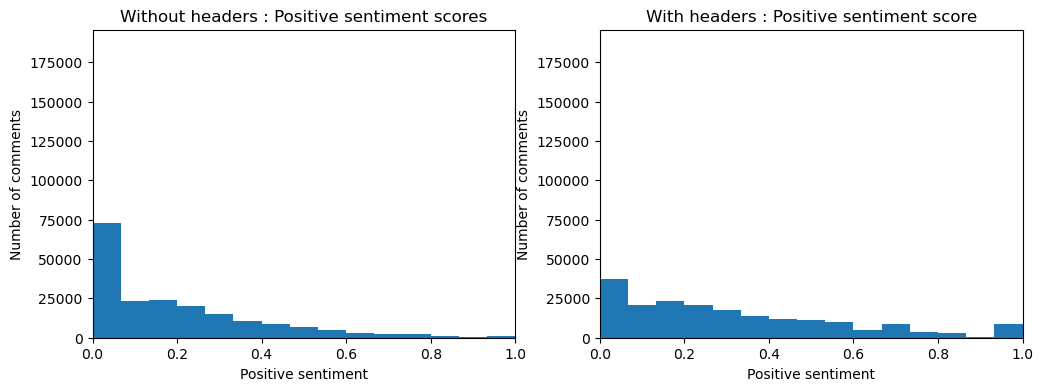

In [58]:
positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in doc]

positive_sent_with_headers = []
[positive_sent_with_headers.append(analyzer.polarity_scores(sent)['pos']) for sent in doc_with_headers]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(positive_sent, bins=15)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 195647])
axs[0].set_xlabel('Positive sentiment')
axs[0].set_ylabel('Number of comments')
axs[0].set_title('Without headers : Positive sentiment scores')

axs[1].hist(positive_sent_with_headers, bins=15)
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 195647])
axs[1].set_xlabel('Positive sentiment')
axs[1].set_ylabel('Number of comments')
axs[1].set_title('With headers : Positive sentiment score')

Text(0.5, 1.0, 'With headers : Negative sentiment score')

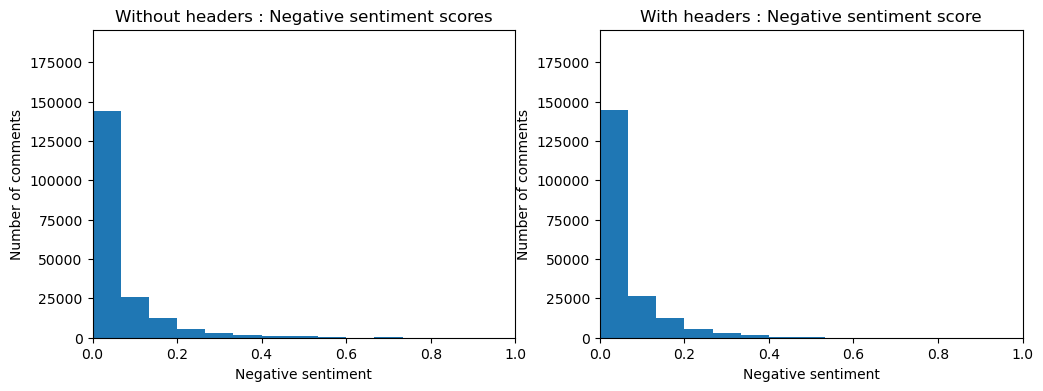

In [59]:
negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in doc]

negative_sent_with_headers = []
[negative_sent_with_headers.append(analyzer.polarity_scores(sent)['neg']) for sent in doc_with_headers]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(negative_sent, bins=15)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 195647])
axs[0].set_xlabel('Negative sentiment')
axs[0].set_ylabel('Number of comments')
axs[0].set_title('Without headers : Negative sentiment scores')

axs[1].hist(negative_sent_with_headers, bins=15)
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 195647])
axs[1].set_xlabel('Negative sentiment')
axs[1].set_ylabel('Number of comments')
axs[1].set_title('With headers : Negative sentiment score')

Text(0.5, 1.0, 'With headers : Compound sentiment score')

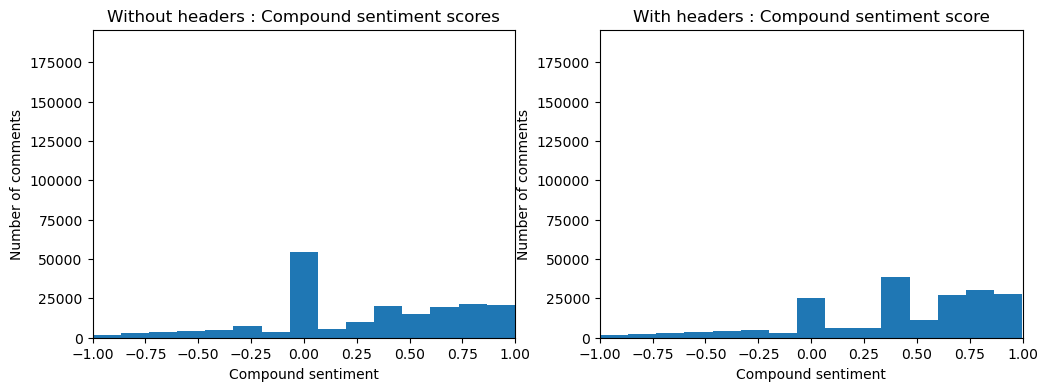

In [71]:
total_sent = []
[total_sent.append(analyzer.polarity_scores(sent)['compound']) for sent in doc]

total_sent_with_headers = []
[total_sent_with_headers.append(analyzer.polarity_scores(sent)['compound']) for sent in doc_with_headers]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(total_sent, bins=15)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([0, 195647])
axs[0].set_xlabel('Compound sentiment')
axs[0].set_ylabel('Number of comments')
axs[0].set_title('Without headers : Compound sentiment scores')

axs[1].hist(total_sent_with_headers, bins=15)
axs[1].set_xlim([-1, 1])
axs[1].set_ylim([0, 195647])
axs[1].set_xlabel('Compound sentiment')
axs[1].set_ylabel('Number of comments')
axs[1].set_title('With headers : Compound sentiment score')

In [63]:
sents = [analyzer.polarity_scores(sent)['compound'] for sent in doc]
print('Number of positive sentences:',sum(np.array(sents)>=0.05))
print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

print("\n With headers : ")
sents_with_headers = [analyzer.polarity_scores(sent)['compound'] for sent in doc_with_headers]
print('Number of positive sentences:',sum(np.array(sents_with_headers)>=0.05))
print('Number of negative sentences:',sum(np.array(sents_with_headers)<=-0.05))
print('Number of neutral sentences:',sum(np.abs(np.array(sents_with_headers))<0.05))

Number of positive sentences: 112613
Number of negative sentences: 30093
Number of neutral sentences: 52941

 With headers : 
Number of positive sentences: 147934
Number of negative sentences: 24062
Number of neutral sentences: 23651


In [73]:
print("Nombre de commentaires :", len(sents))

df_sentiment_with_score = doc.copy().to_frame()
print(type(doc_copy))
df_sentiment_with_score["sent_score"] = sents
df_sentiment_with_score

Nombre de commentaires : 195647
<class 'pandas.core.frame.DataFrame'>


,Parsed_Comment,sent_score
0,as co-nom.,0.0000
1,as nominator.--,0.0000
2,per noms.,0.0000
3,per noms. BDD is a strong contributor with th...,0.4857
4,", with great pleasure. I work with BDD at the ...",0.9100
...,...,...
198270,,0.0000
198271,.,0.0000
198272,. --,0.0000
198273,. Age has nothing to do with maturity. --,0.0000


In [74]:
df_sentiment_with_score.to_csv('df_sentiment_analysis_score_per_comment.csv')